In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 試作版本 => 記得轉平假名和解壓縮前置作業
# Embedding dim = 64
# Embedding vocab_size = 4000

In [2]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F

class BLSTMSpeechScoring(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, num_layers=1, output_size=1, embedding_dim=64, vocab_size=4000):
        super(BLSTMSpeechScoring, self).__init__()

        # 聲學特徵的 BLSTM
        self.acoustic_blstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers, batch_first=True, bidirectional=True)

        # 語言特徵（字符）的 BLSTM
        self.linguistic_blstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                     num_layers=num_layers, batch_first=True, bidirectional=True)

        # 字符的嵌入層
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # 處理 BLSTM 輸出的線性層，以匹配維度
        self.acoustic_linear = nn.Linear(hidden_size * 2, hidden_size)
        self.linguistic_linear = nn.Linear(hidden_size * 2, hidden_size)

        # 串接後的最終線性層
        self.final_linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, acoustic_input, linguistic_input):
        # 聲學輸入通過 BLSTM
        acoustic_output, _ = self.acoustic_blstm(acoustic_input)

        # 將語言輸入嵌入並通過 BLSTM
        embedded_chars = self.embedding(linguistic_input)
        linguistic_output, _ = self.linguistic_blstm(embedded_chars)

        # 線性層確保維度匹配
        acoustic_features = self.acoustic_linear(acoustic_output)
        linguistic_features = self.linguistic_linear(linguistic_output)

        # 對兩輸出進行全局平均池化（GAP）
        gap_acoustic = torch.mean(acoustic_features, dim=1)
        gap_linguistic = torch.mean(linguistic_features, dim=1)

        # 確保在串接之前批量大小相同，怕音檔和文字的數量不對，取完整的
        if gap_acoustic.size(0) != gap_linguistic.size(0):
            min_batch_size = min(gap_acoustic.size(0), gap_linguistic.size(0))
            gap_acoustic = gap_acoustic[:min_batch_size, :]
            gap_linguistic = gap_linguistic[:min_batch_size, :]

        # 串接特徵並最終評分
        concatenated_features = torch.cat((gap_acoustic, gap_linguistic), dim=1)
        concatenated_features = F.relu(concatenated_features)
        score = self.final_linear(concatenated_features)

        return score


# Trainer

In [3]:
from sklearn.metrics import confusion_matrix

jugde = 0.65

class Trainer:
    def __init__(self, model, tokenizer, optimizer, loss_fn, lr_scheduler=None):
        self.model = model
        self.tokenizer = tokenizer
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.lr_scheduler = lr_scheduler

    def training_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        for acoustic_input, text, y_batch in train_loader:
            
            acoustic_input = acoustic_input.to(device)
            y_batch = y_batch.to(device)
            
            self.optimizer.zero_grad()

            encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
            linguistic_input = encoded_input['input_ids'].to(device)
            outputs = self.model(acoustic_input, linguistic_input)
            # print(encoded_input['input_ids'].size())
            # print(encoded_input['input_ids'])
            loss = self.loss_fn(outputs, y_batch) # 改
            additional_loss  = 1.5 * abs((torch.where(outputs > jugde, torch.tensor(1.0), torch.tensor(0.0))) - y_batch)
            additional_loss = additional_loss.mean()
            loss = loss + additional_loss
            loss.backward()

            self.optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Training Loss: {avg_loss}")

    def evaluate(self, eval_loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for acoustic_input, text, y_batch in eval_loader:
                
                acoustic_input = acoustic_input.to(device)
                y_batch = y_batch.to(device)
                
                encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
                linguistic_input = encoded_input['input_ids'].to(device)
                outputs = self.model(acoustic_input, linguistic_input)

                loss = self.loss_fn(outputs, y_batch)
                additional_loss  = 1.5 * abs((torch.where(outputs > jugde, torch.tensor(1.0), torch.tensor(0.0))) - y_batch)
                additional_loss = additional_loss.mean()
                loss = loss + additional_loss
                total_loss += loss.item()
            avg_loss = total_loss / len(eval_loader)
            print(f"Evaluation Loss: {avg_loss}")

    def fit(self, epochs, train_loader):
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}:", end=" ")
            self.training_epoch(train_loader)
            if self.lr_scheduler is not None:
                self.lr_scheduler.step() 

    def pred(self, acoustic_input, text):
        self.model.eval()
        with torch.no_grad():
            
            acoustic_input = acoustic_input.to(device)
            
            encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
            linguistic_input = encoded_input['input_ids'].to(device)
            outputs = self.model(acoustic_input, linguistic_input)
        return outputs

    def confusion_matrix(self, eval_loader):
        self.model.eval()
        all_predictions = []
        all_true_labels = []

        with torch.no_grad():
            for acoustic_input, text, y_batch in eval_loader:
                outputs = self.pred(acoustic_input, text)
                predicted = torch.where(outputs > jugde, torch.tensor(1.0), torch.tensor(0.0))
                all_predictions.extend(predicted.view(-1).tolist())
                all_true_labels.extend(y_batch.view(-1).tolist())

        cm = confusion_matrix(all_true_labels, all_predictions)
        print("Confusion Matrix:\n", cm)

        tn, fp, fn, tp = cm.ravel()
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}", end=f"\n----------------\n")

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (fp + tn) if (fp + tn) > 0 else 0
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"Specificity: {specificity:.2f}")

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        print(f"Accuracy: {accuracy:.2f}")

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"F1 Score: {f1:.2f}")
        return precision, recall, specificity, accuracy, f1

# 怎麼輸入進 Hubert？
## 將音檔先全部輸入進 Hubert得到特徵，再加入文字做成data_loader？

In [4]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained('TKU410410103/wav2vec2-base-japanese-asr')

hubert = Wav2Vec2ForCTC.from_pretrained('TKU410410103/wav2vec2-base-japanese-asr')
hubert.config.output_hidden_states=True
# [batch_size, sequence_length, feature]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hubert.to(device)

In [6]:
import torch
with torch.no_grad():
    output = hubert(torch.rand(1, 16000))
len(output.hidden_states)

13

# 做 dataframe

# (預計) 使用語音辨識產生 text_table

In [7]:
# !unzip -q ./A_class.zip -d ./
# !unzip -q ./B_class.zip -d ./
# !unzip -q ./C_class.zip -d ./

In [7]:
import pandas as pd
import numpy as np

def make_score_table(file_path):
    df_full = pd.read_excel(file_path)
    df_reordered = df_full.set_index('Unnamed: 0').reset_index()
    score_table = df_reordered.replace({'〇': float(1), 'O': float(1), '✖': float(0), 'X': float(0), '×': float(0)})
    score_table.rename(columns={'Unnamed: 0': 'Text'}, inplace=True)
    return score_table


In [8]:
# file_path = '/content/判定のコピー.xlsx'

A_score_table = make_score_table(file_path='./語音辨識判定.xlsx')
B_score_table = make_score_table(file_path='./判定のコピー.xlsx')
C_score_table = make_score_table(file_path='./語音辨識判定(SHIH).xlsx')

# 查表，有分數再加入 dataframe

In [9]:
df = pd.DataFrame(columns=['audio_path', 'text', 'score'])

# 查第N人的所有發音
# if(score == NaN) continue

# for class_name in ['A', 'B', 'C']:
#   for person in range(10):
#     for index in range(23):
#       score = score_table.loc[index][f'音檔{person}']
#       text = score_table.loc[index]['Text']
#       if(score == np.nan):
#         continue

#       df = df.append({'text': text}, ignore_index=True)
#       PATH = f'音檔\切割音檔\{class_name}_class\{class_name}_class_audio_{person+1}\text.mp3'
#       df['audio_path'] = PATH
#       df['score'] = score


rows = []

for class_name, score_table in zip(['A', 'B', 'C'], [A_score_table, B_score_table, C_score_table]):
    for person in range(10-2):
        for index in range(23):
            score = score_table.loc[index, f'音檔{person+1}']
            text = score_table.loc[index, 'Text']
            if pd.isna(score):
                continue
            audio_path = f'./{class_name}_class/{class_name}_class_audio_{person+1}/{text}.mp3'
            rows.append({'audio_path': audio_path, 'text': text, 'score': score})

df = pd.DataFrame(rows)

print(df)


                              audio_path   text  score
0     ./A_class/A_class_audio_1/あのひと.mp3   あのひと    0.0
1     ./A_class/A_class_audio_1/あのかた.mp3   あのかた    1.0
2     ./A_class/A_class_audio_1/みなさん.mp3   みなさん    1.0
3     ./A_class/A_class_audio_1/せんせい.mp3   せんせい    1.0
4     ./A_class/A_class_audio_1/きょうし.mp3   きょうし    0.0
..                                   ...    ...    ...
269   ./C_class/C_class_audio_8/せんせい.mp3   せんせい    0.0
270   ./C_class/C_class_audio_8/きょうし.mp3   きょうし    0.0
271  ./C_class/C_class_audio_8/エンジニア.mp3  エンジニア    1.0
272   ./C_class/C_class_audio_8/だいがく.mp3   だいがく    0.0
273   ./C_class/C_class_audio_8/おいくつ.mp3   おいくつ    1.0

[274 rows x 3 columns]


# 將音檔做處理(採樣率、單聲道)

In [10]:
import torchaudio

def process_waveforms(batch):

    waveform, sample_rate = torchaudio.load(batch['audio_path'])

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    # 如果 waveform 是雙聲道，需要轉單聲道。給 4GE用
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0)

    # 讓 waveform的維度正確
    if waveform.ndim > 1:
        waveform = waveform.squeeze()

    batch["speech_array"] = waveform

    return batch


# 送入 Hubert得到特徵

In [11]:
def get_acoustic_feature(batch):
    with torch.no_grad():
        processed_audios = processor(batch,
                        sampling_rate=16000,
                        return_tensors="pt",
                        padding=True,
                        truncation=True,
                        max_length=160000)
        outputs = hubert(**processed_audios)

    # all layers
    transformer_hidden_states = outputs.hidden_states[:]

    # Stack transformer hidden states to have a new dimension for layers
    stacked_hidden_states = torch.stack(transformer_hidden_states)

    # Average across layers dimension (0) while keeping sequence_length
    overall_avg_hidden_state = torch.mean(stacked_hidden_states, dim=0)

    return overall_avg_hidden_state # [batch_size, sequence_length, featrues]


# 使用自定義 dataset後包成 loader

In [15]:
from torch.utils.data import Dataset

class AudioFeatureDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        audio_data = self.dataset[idx]
        # speech_array_tensor = torch.tensor(audio_data['speech_array'], dtype=torch.float).to(device)
        # print(type(audio_data['speech_array'])) # list
        feature = get_acoustic_feature(audio_data['speech_array'])

        text = audio_data['text']
        score = audio_data['score']

        return feature, text, score


In [16]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import Dataset
import torch.nn.functional as F


def dynamic_padding(batch):
    acoustic_feature, text, score_label = zip(*batch)

    max_len = max([feature.shape[1] for feature in acoustic_feature])

    # Pad each sequence to have the same length
    padded_features = []
    for feature in acoustic_feature:
        pad_amount = max_len - feature.shape[1]

        padded_feature = F.pad(feature, (0, 0, 0, pad_amount), mode='constant', value=0)
        padded_features.append(padded_feature)

    padded_features = torch.stack(padded_features, dim=0)
    # print((padded_features).size())
    # 張量在堆疊後是 4D ([batch_size, 1, seq_len, input_size])，
    # squeeze(1) 來移除大小為 1 的維度(第二維)，以確保輸出是 3D 張量
    padded_features = padded_features.squeeze(1)

    score_label = torch.tensor(score_label, dtype=torch.float)
    score_label = score_label.unsqueeze(-1)
    return padded_features, text, score_label


def make_dataloader(df, batch_size, collate_fn=dynamic_padding):
    audio_path = Dataset.from_pandas(df)
    df = audio_path.map(process_waveforms, remove_columns=['audio_path'])

    dataset = AudioFeatureDataset(df) # should be (tensor(0), text[0], score[0])
    print(df)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return loader


In [17]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
batch_size = 4

train_loader = make_dataloader(df=df_train, batch_size=batch_size)
eval_loader = make_dataloader(df=df_test, batch_size=batch_size)

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'score', '__index_level_0__', 'speech_array'],
    num_rows: 219
})


Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'score', '__index_level_0__', 'speech_array'],
    num_rows: 55
})


In [18]:
(df['score']==1).sum(), (df['score']==0).sum()

(185, 89)

# 放進 BLSTM

In [39]:
# 初始化 Tokenizer 和模型

tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-char")
blstm = BLSTMSpeechScoring().to(device)
loss_fn = nn.MSELoss()

In [40]:
from torch import optim
from torch.optim.lr_scheduler import LambdaLR

num_epoch = 11

def lr_lambda(epoch): # epoch 從 1 開始數
    start_lr = 1.0
    end_lr = 0.5
    
    lr_decay = (start_lr - end_lr) / (num_epoch - 1)

    return max(start_lr - (epoch-1) * lr_decay, end_lr)


optimizer = optim.Adam(blstm.parameters(), lr=8e-5)
lr_scheduler = LambdaLR(optimizer, lr_lambda)
# 1e-4, 8e-5, 4e-5
trainer = Trainer(blstm, tokenizer, optimizer, loss_fn, lr_scheduler)

In [41]:
trainer.fit(epochs=num_epoch, train_loader=train_loader) # additional_loss

Epoch 1/11: Training Loss: 1.5584087258035486
Epoch 2/11: Training Loss: 1.005513692579486
Epoch 3/11: Training Loss: 0.8700797372920946
Epoch 4/11: Training Loss: 0.7509641176936301
Epoch 5/11: Training Loss: 0.6510007550093261
Epoch 6/11: Training Loss: 0.6400254280052402
Epoch 7/11: Training Loss: 0.6894814663312652
Epoch 8/11: Training Loss: 0.6547340529886159
Epoch 9/11: Training Loss: 0.6218817425383762
Epoch 10/11: Training Loss: 0.6007145721804011
Epoch 11/11: Training Loss: 0.5781081480736082


In [42]:
trainer.evaluate(eval_loader=eval_loader)

Evaluation Loss: 0.6541736972119127


In [43]:
precision, recall, specificity, accuracy, f1 = trainer.confusion_matrix(eval_loader=eval_loader)
# True Negatives: 預測 Negative，預測結果正確

# Confusion Matrix:
#  [[13  8]
#  [ 8 26]]
# True Negatives: 13
# False Positives: 8
# False Negatives: 8
# True Positives: 26
# ----------------
# Precision: 0.76
# Recall: 0.76
# Specificity: 0.62
# Accuracy: 0.71
# F1 Score: 0.76


Confusion Matrix:
 [[16  5]
 [12 22]]
True Negatives: 16
False Positives: 5
False Negatives: 12
True Positives: 22
----------------
Precision: 0.81
Recall: 0.65
Specificity: 0.76
Accuracy: 0.69
F1 Score: 0.72


In [242]:
acoustic_input, text, y_batch = next(iter(eval_loader))

In [243]:
trainer.pred(acoustic_input, text) # 在做loss計算之前預測的分數都一樣，練太少或是長度太短？ random seed

# 100 -> 優
# .80 -> 佳
# .60 -> 可
# .40 -> 尚可
# .20 -> 差
# ..0 -> 劣



tensor([[0.3805],
        [0.4536],
        [0.9160],
        [0.4843]], device='cuda:0')

In [244]:
text, y_batch

(('エンジニア', 'エンジニア', 'なんさい', 'あのひと'),
 tensor([[0.],
         [1.],
         [1.],
         [1.]]))

# 隨著 epochs上升，對 不標準的發音 的判斷變好。

# 繪圖，使用相同模型，judge = 0.5 下，模型表現視覺化
learning_rate = [1e-4, 5e-5, 5e-5, 1e-5, 1e-5, 1e-6]

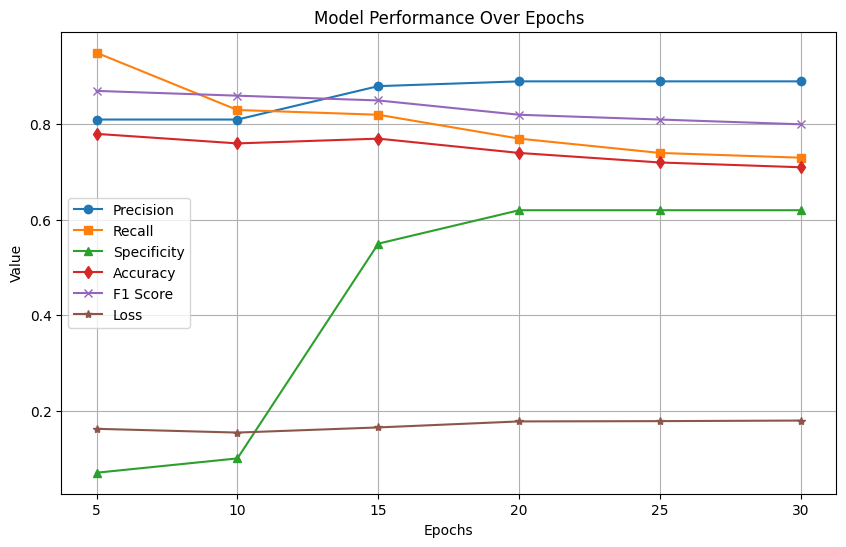

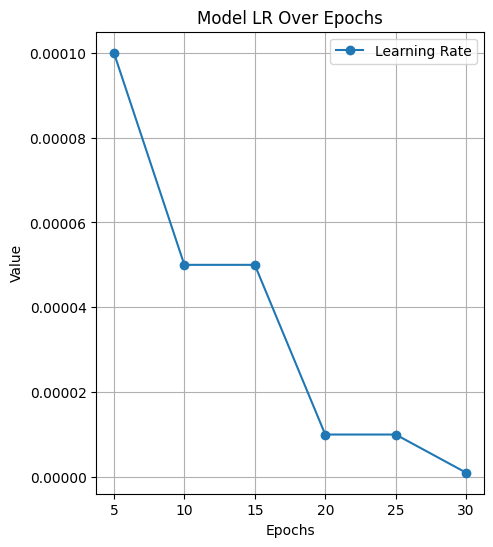

In [ ]:
# import matplotlib.pyplot as plt

# epochs = [5, 10, 15, 20, 25, 30]
# precision = [0.81, 0.81, 0.88, 0.89, 0.89, 0.89]
# recall = [0.95, 0.83, 0.82, 0.77, 0.74, 0.73]
# specificity = [0.07, 0.10, 0.55, 0.62, 0.62, 0.62]
# accuracy = [0.78, 0.76, 0.77, 0.74, 0.72, 0.71]
# f1_score = [0.87, 0.86, 0.85, 0.82, 0.81, 0.80]
# loss = [0.1620, 0.1541, 0.1649, 0.1775, 0.1781, 0.1793]

# learning_rate = [1e-4, 5e-5, 5e-5, 1e-5, 1e-5, 1e-6]

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, precision, marker='o', linestyle='-', label='Precision')
# plt.plot(epochs, recall, marker='s', linestyle='-', label='Recall')
# plt.plot(epochs, specificity, marker='^', linestyle='-', label='Specificity')
# plt.plot(epochs, accuracy, marker='d', linestyle='-', label='Accuracy')
# plt.plot(epochs, f1_score, marker='x', linestyle='-', label='F1 Score')
# plt.plot(epochs, loss, marker='*', linestyle='-', label='Loss')

# plt.title('Model Performance Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Value')
# plt.legend()

# plt.xticks(epochs)

# plt.grid()

# plt.figure(figsize=(5, 6))
# plt.plot(epochs, learning_rate, marker='o', linestyle='-', label='Learning Rate')
# plt.title('Model LR Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Value')
# plt.legend()

# plt.xticks(epochs)

# plt.grid()
# plt.show()

In [39]:
# import os

# folder_path = './'
# os.makedirs(folder_path, exist_ok=True)  # 創建資料夾，如果已存在則忽略

# model_save_path = os.path.join(folder_path, 'BLSTMSpeechScoring_0410.pth')

# torch.save(blstm.state_dict(), model_save_path)